In [40]:
cmaps = [
    '/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-0001/func/sub-0001_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
]
anats = [
    '/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-0001/anat/sub-0001_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
]

In [20]:
func_data = nib.load('/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-0001/func/sub-0001_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')\
    .get_fdata()

In [21]:
func_data.shape

(60, 77, 65, 290)

In [84]:
bold_nifti = nib.load('/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-0001/func/sub-0001_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')


In [92]:
bold_nifti.slicer[:, :, :, 0]

In [89]:
bold_nifti[:, :, :, 0]

TypeError: Cannot slice image objects; consider using `img.slicer[slice]` to generate a sliced image (see documentation for caveats) or slicing image array data with `img.dataobj[slice]` or `img.get_fdata()[slice]`

In [66]:
avg_func_data.shape

(60, 77, 65)

In [24]:
avg_func_data = func_data.mean(axis=3)

In [18]:
data = nib.load('/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-0001/anat/sub-0001_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz')\
    .get_fdata()

In [19]:
data.shape

(193, 229, 193)

In [4]:
from fetcher import fetch_difumo

In [5]:
maps_img = fetch_difumo(dimension=64).maps


Dataset created in /home/jovyan/nilearn_data/difumo_atlases



 ...done. (1 seconds, 0 min)
Extracting data from /home/jovyan/nilearn_data/difumo_atlases/32f20c435284180ce992c1b88c078b40/download..... done.


 ...done. (2 seconds, 0 min)


In [6]:
from nilearn.input_data import NiftiMapsMasker

maps_masker = NiftiMapsMasker(maps_img=maps_img, verbose=1)

/srv/conda/envs/notebook/lib/python3.7/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [26]:
import numpy as np

In [67]:
func_data[:, :, :, 0].shape

(60, 77, 65)

In [70]:
from tqdm.notebook import tqdm

In [93]:
sub = 10

In [95]:
f'{sub:04}'

'0010'

In [98]:
fnames = []
for sub in range(1, 9):
    fnames.append(f'/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-{sub:04}/func/sub-{sub:04}_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

for sub in range(10, 101):
    fnames.append(f'/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-{sub:04}/func/sub-{sub:04}_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')


In [100]:
'shared/ds003097/derivatives/fmriprep/sub-0010/func/sub-0010_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

'shared/ds003097/derivatives/fmriprep/sub-0010/func/sub-0010_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

In [99]:
fnames

['/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-0001/func/sub-0001_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-0002/func/sub-0002_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-0003/func/sub-0003_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-0004/func/sub-0004_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-0005/func/sub-0005_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-0006/func/sub-0006_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-0007/func/sub-0007_task-moviewatching_space-MNI152NLin2009cAsy

In [97]:
subjects_fmri = []

for sub in range(1, 9):
    subjects_fmri.append(nib.load(f'/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-{sub:04}/func/sub-{sub:04}_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))

for sub in range(10, 101):
    subjects_fmri.append(nib.load(f'/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-{sub:04}/func/sub-{sub:04}_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))


FileNotFoundError: No such file or no access: '/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-0010/func/sub-0010_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

In [ ]:
num_frames = 290

for time in tqdm(range(num_frames), desc='Time'):
    
    
    
    time_signal = 

In [72]:
signals_list = []

for i in tqdm(range(10)):
    zeroth_func_data = func_data[:, :, :, i]
    zeroth_nift = nib.Nifti1Image(zeroth_func_data, np.eye(4))
    signals = maps_masker.fit_transform([zeroth_nift])
    signals_list.append(signals)

  0%|          | 0/10 [00:00<?, ?it/s]

[NiftiMapsMasker.fit_transform] loading regions from /home/jovyan/nilearn_data/difumo_atlases/64/2mm/maps.nii.gz
[NiftiMapsMasker.transform_single_imgs] Loading data from [Nifti1Image(
shape=(60, 77, 65),
affine=array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])
)]
[NiftiMapsMasker.transform_single_imgs] Extracting region signals
[NiftiMapsMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMapsMasker.fit_transform] loading regions from /home/jovyan/nilearn_data/difumo_atlases/64/2mm/maps.nii.gz
[NiftiMapsMasker.transform_single_imgs] Loading data from [Nifti1Image(
shape=(60, 77, 65),
affine=array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])
)]
[NiftiMapsMasker.transform_single_imgs] Extracting region signals
[NiftiMapsMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMapsMasker.fit_transform] loading regions from /home/jovyan/nilearn_data/difumo_atlases/64/2mm/m

In [74]:
len(signals_list)

10

In [77]:
np.array(signals_list).shape

(10, 1, 64)

In [78]:
(290, 980, 64)

(290, 980, 64)

In [79]:
(980, 290, 64)

(980, 290, 64)

In [80]:
(980, 64*63/2)

(980, 2016.0)

In [30]:
signals.shape

(1, 64)

In [31]:
signals

array([[ 6.51182440e+07,  3.09538144e+17, -2.36104313e+18,
        -5.03109944e+10, -1.40495195e+10,  1.66625070e+07,
        -4.23496295e+07,  2.39554252e+08, -8.30688827e+17,
         3.19877475e+05, -4.61184112e+17, -2.27025982e+09,
         1.02500932e+18, -1.95787780e+13, -2.02846965e+05,
        -6.39303105e+17, -8.28328187e+05,  8.41829141e+19,
        -7.18328862e+05, -8.30505801e+17, -1.50417874e+17,
         3.29046420e+06,  9.27290237e+06, -2.17245819e+16,
         3.50241145e+06,  1.95374529e+06, -1.42240896e+20,
         3.06089013e+11, -1.14638229e+14,  1.99723549e+06,
        -4.83365959e+14,  2.49681697e+16,  5.30553212e+10,
        -1.15712000e+05, -1.38276046e+16,  7.04020480e+07,
        -1.72651520e+07, -2.93276385e+17,  5.08416000e+06,
        -1.47660800e+06, -2.45760000e+04,  9.32546961e+14,
        -4.21836033e+09,  1.07004390e+09,  1.94150400e+06,
        -1.14688000e+06, -1.04857600e+06, -1.92246498e+14,
         1.39325440e+07,  5.09845317e+18,  2.90467840e+0

In [32]:
compressed_maps = maps_masker.inverse_transform(signals)

[NiftiMapsMasker.inverse_transform] computing image from signals


In [34]:
compressed_maps.shape

(104, 123, 104, 1)

In [41]:
anats

['/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-0001/anat/sub-0001_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz']

In [47]:
cut_coords

[[29.005821653842865, 36.46844197649144, 30.359632473056887]]

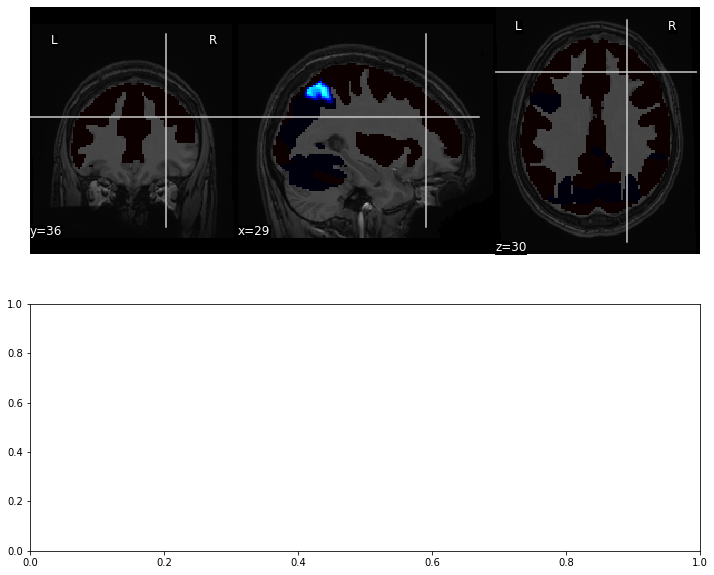

In [48]:
from nilearn.image import iter_img


fig, axes = plt.subplots(figsize=(12, 10), ncols=1, nrows=2)
axes = axes.reshape(-1)

for i, (anat_img, cmap) in enumerate(zip(anats, iter_img(compressed_maps))):
    plotting.plot_stat_map(cmap, bg_img=anat_img, 
                           figure=fig, axes=axes[i],
                           colorbar=False, cut_coords=cut_coords[i])

In [64]:
anats

['/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-0001/anat/sub-0001_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz']

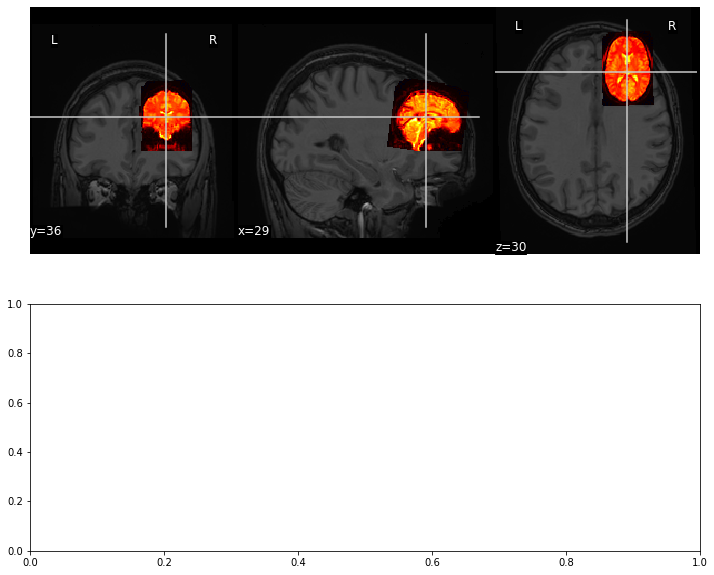

In [46]:
import matplotlib.pyplot as plt
from nilearn import plotting

fig, axes = plt.subplots(figsize=(12, 10), ncols=1, nrows=2)
axes = axes.reshape(-1)

cut_coords = []
zeroth_func_data = nib.Nifti1Image(func_data[:, :, :, 0], np.eye(4))

for i, (anat_img, cmap) in enumerate(zip(anats, [zeroth_func_data])):
    display = plotting.plot_stat_map(cmap, bg_img=anat_img,
                                     figure=fig, axes=axes[i],
                                     colorbar=False)
    cut_coords.append(display.cut_coords)


Contrasts

In [8]:
from nilearn.datasets import fetch_localizer_contrasts

localizer_data = fetch_localizer_contrasts(contrasts=["sentence listening"],
                                           n_subjects=10, get_anats=True)
cmaps = localizer_data.cmaps
anats = localizer_data.anats

/srv/conda/envs/notebook/lib/python3.7/site-packages/nilearn/datasets/func.py:764: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


In [9]:
cmaps

['/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S01/cmaps_AuditorySentences.nii.gz',
 '/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S02/cmaps_AuditorySentences.nii.gz',
 '/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S03/cmaps_AuditorySentences.nii.gz',
 '/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S04/cmaps_AuditorySentences.nii.gz',
 '/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S05/cmaps_AuditorySentences.nii.gz',
 '/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S06/cmaps_AuditorySentences.nii.gz',
 '/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S07/cmaps_AuditorySentences.nii.gz',
 '/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S08/cmaps_AuditorySentences.nii.gz',
 '/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S09/cmaps_AuditorySentences.nii.gz',
 '/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S10/cmaps_Auditor

In [10]:
import nibabel as nib

In [60]:
data = nib.load('/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S10/cmaps_AuditorySentences.nii.gz')\
    .get_fdata()

In [61]:
data.shape

(53, 63, 46)

In [62]:
np.nanmin(data)

-43.43663787841797

In [63]:
np.nanmax(data)

59.020713806152344

In [13]:
anats


['/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S01/normalized_T1_anat_defaced.nii.gz',
 '/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S02/normalized_T1_anat_defaced.nii.gz',
 '/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S03/normalized_T1_anat_defaced.nii.gz',
 '/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S04/normalized_T1_anat_defaced.nii.gz',
 '/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S05/normalized_T1_anat_defaced.nii.gz',
 '/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S06/normalized_T1_anat_defaced.nii.gz',
 '/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S07/normalized_T1_anat_defaced.nii.gz',
 '/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S08/normalized_T1_anat_defaced.nii.gz',
 '/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S09/normalized_T1_anat_defaced.nii.gz',
 '/home/jovyan/nilearn_data/brainomics_localizer/braino

In [14]:
data = nib.load('/home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S01/normalized_T1_anat_defaced.nii.gz')\
    .get_fdata()

In [15]:
data.shape

(157, 189, 136)